In [829]:
import pandas as pd
import numpy as np
import datetime 
import os

# Scikit-learn imports
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.utils import class_weight


# Machine learning libraries
import xgboost as xgb
import lightgbm as lgb


# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Warning settings
pd.set_option('future.no_silent_downcasting', True)


ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
data = pd.read_csv('../data/Telco-Customer-Churn_cleaned.csv')
df = data.copy()

In [ ]:
df.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
# Inspecting columns and unique values
def unique_value_report(df):
    rows = []
    for col in df.columns:
        value_counts = df[col].value_counts(dropna=False)
        formatted = ', '.join([f"{val} ({count})" for val, count in value_counts.items()])
        rows.append({'variable': col, 'values': formatted})
    return pd.DataFrame(rows)

unique_value_report(df)


,variable,values
0,Gender,"male (3555), female (3488)"
1,SeniorCitizen,"no (5901), yes (1142)"
2,Partner,"no (3641), yes (3402)"
3,Dependents,"no (4933), yes (2110)"
4,Tenure,"1 (613), 72 (362), 2 (238), 3 (200), 4 (176), ..."
5,PhoneService,"yes (6361), no (682)"
6,MultipleLines,"no (3390), yes (2971), no phone service (682)"
7,InternetService,"fiber optic (3096), dsl (2421), no (1526)"
8,OnlineSecurity,"no (3498), yes (2019), no internet service (1526)"
9,OnlineBackup,"no (3088), yes (2429), no internet service (1526)"


In [ ]:
# 1. Identyfying columns for preprocessing

# Columns categorization
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

## Identify binary columns with only 'yes' and 'no' values
binary_yn_cols = [col for col in df.select_dtypes(include=['object']).columns if set(df[col].unique()) == {'yes', 'no'} and col not in ['Churn']]

## Identify ordinal columns
ordinal_cols = ['Contract']
ordinal_categories = [['month-to-month', 'one year', 'two year']]  # Ordre logique des contrats

## Nominal columns: object columns with more than 2 unique values, excluding ordinal and binary columns
categorical_cols = [col for col in df.select_dtypes(include=['object']).columns if col not in ordinal_cols and df[col].nunique() > 2]


In [ ]:
target_col = 'Churn'  # Target variable

# Split train / val / test
X_train, X_temp, y_train, y_temp = train_test_split(
    df.drop(columns=[target_col]), df[target_col], test_size=0.3, random_state=42, stratify=df[target_col])

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [ ]:
X_train.shape, X_test.shape, X_val.shape, X_test.shape, y_val.shape, y_test.shape

((4930, 19), (1057, 19), (1056, 19), (1057, 19), (1056,), (1057,))

In [ ]:
# 2. Normalisation sur les numériques
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols])
X_val_num = scaler.transform(X_val[numerical_cols])
X_test_num = scaler.transform(X_test[numerical_cols])

X_train_num.shape, X_val_num.shape, X_test_num.shape

((4930, 3), (1056, 3), (1057, 3))

In [ ]:
# 3. Encodage sur les catégorielles
# Encodage des colonnes binaires yes/no en 0/1
map = {'yes': 1, 'no': 0}
X_train[binary_yn_cols] = X_train[binary_yn_cols].replace(map)
X_val[binary_yn_cols] = X_val[binary_yn_cols].replace(map)
X_test[binary_yn_cols] = X_test[binary_yn_cols].replace(map)

# One-hot encoding for nominal categorical columns and 
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[categorical_cols])
X_val_cat = encoder.transform(X_val[categorical_cols])
X_test_cat = encoder.transform(X_test[categorical_cols])

# Ordinal encoding for ordinal columns
ordinal = OrdinalEncoder(categories=ordinal_categories)
X_train_ordinal = ordinal.fit_transform(X_train[ordinal_cols])
X_val_ordinal = ordinal.transform(X_val[ordinal_cols])
X_test_ordinal = ordinal.transform(X_test[ordinal_cols])




In [ ]:
X_train_num = np.array(X_train_num)
X_train_cat = np.array(X_train_cat)
X_train_ordinal = np.array(X_train_ordinal)

# 4. Concatenation des numériques et catégorielles
X_train_final = np.hstack([X_train_num, X_train_cat, X_train_ordinal])
X_val_final = np.hstack([X_val_num, X_val_cat, X_val_ordinal])
X_test_final = np.hstack([X_test_num, X_test_cat, X_test_ordinal])

X_train_final.shape, X_val_final.shape, X_test_final.shape

((4930, 32), (1056, 32), (1057, 32))

In [ ]:
# 5. Target variable encoding
map_target = {'yes': 1, 'no': 0}
y_train_end = y_train.replace(map_target)
y_val_end = y_val.replace(map_target)
y_test_end = y_test.replace(map_target)

## Final conversion to numpy arrays
y_train_final = y_train_end.to_numpy()
y_val_final = y_val_end.to_numpy()
y_test_final = y_test_end.to_numpy()

y_train_final = y_train_final.astype(np.float32)
y_val_final = y_val_final.astype(np.float32)
y_test_final = y_test_final.astype(np.float32)

y_train_final.shape, y_val_final.shape, y_test_final.shape

((4930,), (1056,), (1057,))

In [ ]:
# 6. Class weights for imbalanced classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(0.680563224737714), 1: np.float64(1.8845565749235473)}


In [ ]:
input_dim = X_train_final.shape[1]

def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

In [ ]:
model = build_model(input_dim)
model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,337 (24.75 KB)

 Trainable params: 6,337 (24.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    # mode='max',
    restore_best_weights=True,
    verbose=1
)

checkpoint_path = "data/churn_best.keras"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

tensorboard_cb = callbacks.TensorBoard(log_dir='./logs')

In [ ]:
# Entraînement
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, model_checkpoint, tensorboard_cb]
)


Epoch 1/100


141/155 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7012 - auc: 0.7877 - loss: 0.5682 - precision: 0.4673 - recall: 0.7581
Epoch 1: val_accuracy improved from -inf to 0.72064, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7039 - auc: 0.7904 - loss: 0.5639 - precision: 0.4699 - recall: 0.7596 - val_accuracy: 0.7206 - val_auc: 0.8416 - val_loss: 0.5129 - val_precision: 0.4844 - val_recall: 0.8321
Epoch 2/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7443 - auc: 0.8466 - loss: 0.4809 - precision: 0.5084 - recall: 0.7896
Epoch 2: val_accuracy improved from 0.72064 to 0.72159, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7443 - auc: 0.8465 - loss: 0.4809 - precision: 0.5084 - recall: 0.7897 - val_accuracy: 0.7216 - val_auc: 0.8450 - val_loss: 0.5320 - val_precision: 0.4854 - val_recall: 0.8321
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7464 - auc: 0.8541 - loss: 0.4717 - precision: 0.5095 - recall: 0.8097
Epoch 3: val_accuracy improved from 0.72159 to 0.72538, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7464 - auc: 0.8540 - loss: 0.4718 - precision: 0.5095 - recall: 0.8096 - val_accuracy: 0.7254 - val_auc: 0.8453 - val_loss: 0.5173 - val_precision: 0.4894 - val_recall: 0.8214
Epoch 4/100
151/155 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7385 - auc: 0.8485 - loss: 0.4815 - precision: 0.5018 - recall: 0.8196
Epoch 4: val_accuracy improved from 0.72538 to 0.72822, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7387 - auc: 0.8484 - loss: 0.4816 - precision: 0.5021 - recall: 0.8192 - val_accuracy: 0.7282 - val_auc: 0.8462 - val_loss: 0.5177 - val_precision: 0.4924 - val_recall: 0.8143
Epoch 5/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7582 - auc: 0.8557 - loss: 0.4725 - precision: 0.5367 - recall: 0.8021
Epoch 5: val_accuracy improved from 0.72822 to 0.75473, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7581 - auc: 0.8556 - loss: 0.4725 - precision: 0.5366 - recall: 0.8021 - val_accuracy: 0.7547 - val_auc: 0.8438 - val_loss: 0.4839 - val_precision: 0.5251 - val_recall: 0.7857
Epoch 6/100
152/155 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7489 - auc: 0.8463 - loss: 0.4855 - precision: 0.5284 - recall: 0.7935
Epoch 6: val_accuracy did not improve from 0.75473
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7489 - auc: 0.8464 - loss: 0.4853 - precision: 0.5281 - recall: 0.7936 - val_accuracy: 0.7434 - val_auc: 0.8450 - val_loss: 0.4983 - val_precision: 0.5102 - val_recall: 0.8036
Epoch 7/100
146/155 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7642 - auc: 0.8464 - loss: 0.4816 - precision: 0.5297 - recall: 0.7610
Epoch 7: val_accuracy did not improve from 0.75473
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7637 - auc: 0.8467 - loss: 0.4812 - precision: 0.5296 - recall: 0.7633 - val_accuracy: 0.7443 - val_auc: 

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7472 - auc: 0.8556 - loss: 0.4646 - precision: 0.5103 - recall: 0.7950 - val_accuracy: 0.7566 - val_auc: 0.8407 - val_loss: 0.4812 - val_precision: 0.5283 - val_recall: 0.7679
Epoch 14/100
152/155 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7581 - auc: 0.8582 - loss: 0.4602 - precision: 0.5153 - recall: 0.7999
Epoch 14: val_accuracy improved from 0.75663 to 0.76515, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7581 - auc: 0.8583 - loss: 0.4601 - precision: 0.5157 - recall: 0.8003 - val_accuracy: 0.7652 - val_auc: 0.8399 - val_loss: 0.4620 - val_precision: 0.5423 - val_recall: 0.7321
Epoch 15/100
Epoch 15/100
146/155 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7694 - auc: 0.8621 - loss: 0.4606 - precision: 0.5454 - recall: 0.8066
Epoch 15: val_accuracy did not improve from 0.76515
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7691 - auc: 0.8622 - loss: 0.4603 - precision: 0.5449 - recall: 0.8068 - val_accuracy: 0.7282 - val_auc: 0.8397 - val_loss: 0.5262 - val_precision: 0.4924 - val_recall: 0.8071
Epoch 16/100
153/155 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7780 - auc: 0.8745 - loss: 0.4325 - precision: 0.5442 - recall: 0.8297
Epoch 16: val_accuracy did not improve from 0.76515
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7778 - auc: 0.8743 - loss: 0.4329 - precision: 0.5441 - recall: 0.8294 - val_accuracy:

In [ ]:
accuracy, auc, loss, precision, recall = model.evaluate(X_test_final, y_test_final, verbose=0)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

Test Accuracy: 0.4507
Test AUC: 0.7720
Test Precision: 0.5559
Test Recall: 0.7082


In [ ]:
# Prédictions : probabilités
y_pred_probs = model.predict(X_test_final)

# Binarisation à 0.5 (seuil par défaut)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# y_test_final est un array de 0 et 1
print("\nClassification Report :")
print(classification_report(y_test_final, y_pred, target_names=['No Churn', 'Churn']))


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report :
              precision    recall  f1-score   support

    No Churn       0.88      0.80      0.84       776
       Churn       0.56      0.71      0.62       281

    accuracy                           0.77      1057
   macro avg       0.72      0.75      0.73      1057
weighted avg       0.80      0.77      0.78      1057



- Precision (précision) : parmi les exemples prédits positifs, combien sont réellement positifs.
- Recall (rappel) : parmi les exemples réellement positifs, combien ont été détectés (sensibilité).
- F1-score : moyenne harmonique entre précision et rappel, équilibre les deux métriques.
- Support : nombre d'exemples réels dans chaque classe.


### **Analyse des résultats**
**Classe No Churn (non-départ)**
* Précision élevée (0.90) : Quand le modèle prédit "No Churn", il a raison 90 % du temps.
* Rappel plus faible (0.74) : Le modèle détecte 74 % des vrais "No Churn", il manque donc 26 % de ces cas (faux négatifs).
* F1-score solide (0.81), ce qui indique un bon compromis.

**Classe Churn (départ)**
* Précision faible (0.52) : Parmi les prédictions "Churn", seul 52 % sont correctes. Beaucoup de faux positifs.
* Rappel plus élevé (0.78) : Le modèle détecte 78 % des vrais départs, il manque 22 % (faux négatifs).
* F1-score moyen (0.62), indiquant une performance moins satisfaisante pour cette classe.

**Performance globale**
* Accuracy de 0.75 : 75 % des prédictions globales sont correctes, mais ce chiffre est à nuancer car les classes sont déséquilibrées (plus de No Churn).
* La moyenne macro (qui donne un poids égal aux classes) est plus basse (F1-score 0.72), ce qui montre que la performance sur la classe minoritaire (Churn) tire vers le bas la moyenne.

### **Interprétation business & recommandations**
- ***Déséquilibre de classes*** : Le nombre de "No Churn" est presque 3 fois celui des "Churn". L’accuracy seule peut être trompeuse dans ce cas.
- ***Précision faible sur Churn*** : Le modèle génère beaucoup de faux positifs — en pratique, cela signifie que beaucoup de clients sont faussement identifiés comme partants.
- ***Rappel élevé sur Churn*** : Le modèle détecte une majorité des vrais clients partants, ce qui est important si l’objectif est de réduire le churn en intervenant tôt.

In [ ]:
print("Matrice de Confusion :")
cm = confusion_matrix(y_test_final, y_pred)
print(cm)

Matrice de Confusion :
[[617 159]
 [ 82 199]]


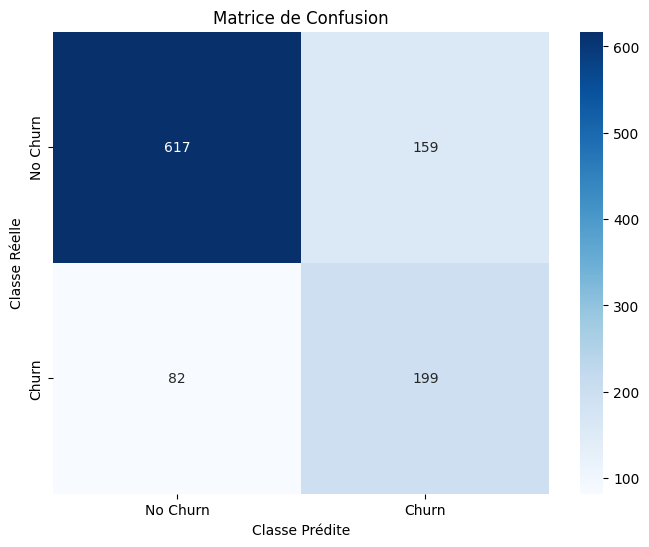

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Matrice de Confusion")
plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")
plt.show()

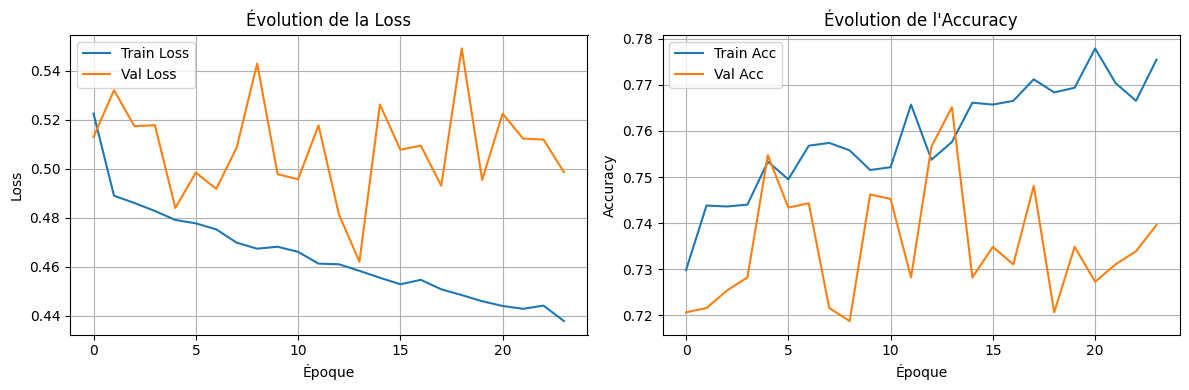

In [ ]:
def plot_loss_acc(history, validation=True):
    """
    Trace la loss et l'accuracy du modèle pendant l'entraînement.
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if validation and 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if validation and 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Évolution de l'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_loss_acc(history)

### 3. TensorBoard

TensorBoard est un outil de visualisation et de suivi des métriques d'entraînement des modèles de Deep Learning. Il permet d'explorer les performances du modèle, de diagnostiquer les problèmes et d'optimiser les hyperparamètres. Grâce à ses fonctionnalités interactives, TensorBoard offre une vue d'ensemble des courbes de perte et d'accuracy, des distributions des poids, des gradients, et bien plus encore.

Voici quelques-unes des fonctionnalités principales de TensorBoard :
- **Suivi des métriques** : Visualisation des courbes de perte, d'accuracy, etc.
- **Exploration des distributions** : Histogrammes des poids et des gradients.
- **Visualisation du graphe du modèle** : Compréhension de la structure du réseau.
- **Analyse des hyperparamètres** : Comparaison des performances pour différents réglages.

TensorBoard est un outil essentiel pour tout projet de Deep Learning, facilitant l'interprétation des résultats et l'amélioration des modèles.

* **`log_dir`** : dossier où seront écrits les logs (scalars, histogrammes, graph, images).

* **`histogram_freq=1`** : enregistre chaque époque les distributions de poids et de gradients.

* **`write_graph=True`** : sauvegarde la définition du modèle pour visualiser le graph.

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
log_dir = os.path.join(
    "logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,       # enregistre les histogrammes de poids chaque époque
    write_graph=True,       # sauvegarde le graph du modèle
    write_images=True
)

In [ ]:
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, model_checkpoint, tensorboard_cb]
)


Epoch 1/100
148/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7672 - auc: 0.8589 - loss: 0.4613 - precision: 0.5441 - recall: 0.8080
Epoch 1: val_accuracy did not improve from 0.76515
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7671 - auc: 0.8591 - loss: 0.4610 - precision: 0.5439 - recall: 0.8083 - val_accuracy: 0.7254 - val_auc: 0.8376 - val_loss: 0.5212 - val_precision: 0.4893 - val_recall: 0.8143
Epoch 2/100
139/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7621 - auc: 0.8654 - loss: 0.4587 - precision: 0.5430 - recall: 0.8377
Epoch 2: val_accuracy improved from 0.76515 to 0.77178, saving model to best_model.h5


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7623 - auc: 0.8653 - loss: 0.4582 - precision: 0.5423 - recall: 0.8372 - val_accuracy: 0.7718 - val_auc: 0.8370 - val_loss: 0.4497 - val_precision: 0.5549 - val_recall: 0.7036
Epoch 3/100
Epoch 3/100
150/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7804 - auc: 0.8685 - loss: 0.4535 - precision: 0.5628 - recall: 0.8045
Epoch 3: val_accuracy did not improve from 0.77178
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7800 - auc: 0.8684 - loss: 0.4535 - precision: 0.5621 - recall: 0.8045 - val_accuracy: 0.7330 - val_auc: 0.8368 - val_loss: 0.5207 - val_precision: 0.4978 - val_recall: 0.8143
Epoch 4/100
143/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7743 - auc: 0.8734 - loss: 0.4434 - precision: 0.5489 - recall: 0.8327
Epoch 4: val_accuracy did not improve from 0.77178
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7742 - auc: 0.8731 - loss: 0.4438 - precision: 0.5489 - recall: 0.8320 - val_accuracy: 0.7386

In [ ]:
test_acc, test_auc, test_loss, test_precesion, test_recall  = model.evaluate(X_test_final, y_test_final, verbose=0)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precesion:.4f}")
print(f"Test Recall: {test_recall:.4f}")

Test Accuracy: 0.4383
Test AUC: 0.7777
Test Precision: 0.5706
Test Recall: 0.6619


In [ ]:
# Prédictions : probabilités
y_pred_probs = model.predict(X_test_final)

# Binarisation à 0.5 (seuil par défaut)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# y_test_final est un array de 0 et 1
print("\nClassification Report :")
print(classification_report(y_test_final, y_pred, target_names=['No Churn', 'Churn']))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Classification Report :
              precision    recall  f1-score   support

    No Churn       0.87      0.82      0.84       776
       Churn       0.57      0.66      0.61       281

    accuracy                           0.78      1057
   macro avg       0.72      0.74      0.73      1057
weighted avg       0.79      0.78      0.78      1057



In [ ]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6007 (pid 127553), started 1:30:36 ago. (Use '!kill 127553' to kill it.)

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_final, y_train_final)

In [ ]:
# Entraînement
history = model.fit(
    X_train_res, y_train_res,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint, tensorboard_cb]
)

Epoch 1/100


150/155 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7672 - auc: 0.8634 - loss: 0.4550 - precision: 0.5459 - recall: 0.7883
Epoch 1: val_accuracy did not improve from 0.77178
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7672 - auc: 0.8635 - loss: 0.4549 - precision: 0.5457 - recall: 0.7893 - val_accuracy: 0.7292 - val_auc: 0.8361 - val_loss: 0.5200 - val_precision: 0.4933 - val_recall: 0.7893
Epoch 2/100
142/155 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7668 - auc: 0.8669 - loss: 0.4589 - precision: 0.5575 - recall: 0.8396
Epoch 2: val_accuracy did not improve from 0.77178
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7667 - auc: 0.8670 - loss: 0.4582 - precision: 0.5558 - recall: 0.8384 - val_accuracy: 0.7623 - val_auc: 0.8352 - val_loss: 0.4838 - val_precision: 0.5363 - val_recall: 0.7643
Epoch 3/100
150/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7731 - auc: 0.8705 - loss: 0.4429 - precision: 0.5474 - recall: 0.7948
Epoch 3: val_accuracy did not impr

In [ ]:
# Prédictions : probabilités
y_pred_probs = model.predict(X_test_final)

# Binarisation à 0.5 (seuil par défaut)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# y_test_final est un array de 0 et 1
print("\nClassification Report :")
print(classification_report(y_test_final, y_pred, target_names=['No Churn', 'Churn']))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Classification Report :
              precision    recall  f1-score   support

    No Churn       0.89      0.78      0.83       776
       Churn       0.55      0.74      0.63       281

    accuracy                           0.77      1057
   macro avg       0.72      0.76      0.73      1057
weighted avg       0.80      0.77      0.78      1057



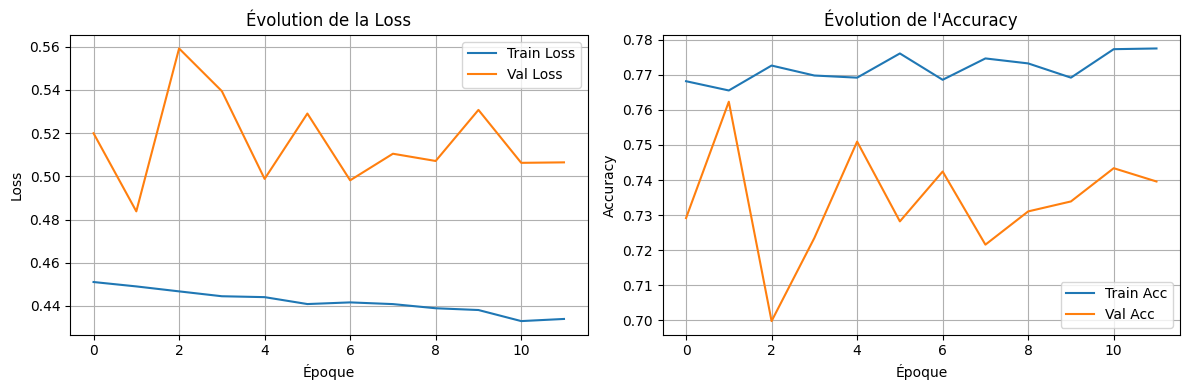

In [ ]:
def plot_loss_acc(history, validation=True):
    """
    Trace la loss et l'accuracy du modèle pendant l'entraînement.
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if validation and 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époque')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    if validation and 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Évolution de l'Accuracy")
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_loss_acc(history)

In [ ]:
type(X_train_res)

numpy.ndarray

In [ ]:
X_train_final.shape, y_train_final.shape, X_train_res.shape, y_train_res.shape

((4930, 32), (4930,), (7244, 32), (7244,))

In [839]:
# Si y_train_res est un DataFrame ou Series avec type object
if isinstance(y_train_res, (pd.Series, pd.DataFrame)):
    y_train_res = y_train_res.values.ravel()

# Convertir en int si ce sont des labels de classification
y_train_res = y_train_res.astype(np.int32)

In [838]:
import xgboost as xgb
print(xgb.__version__)


3.0.1


In [847]:
import numpy as np
import pandas as pd

# Vérifier et préparer X_train_res
if isinstance(X_train_res, pd.DataFrame):
    X_train_res = X_train_res.values
assert not np.any(pd.isnull(X_train_res)), "NaN detected in X_train_res"
assert not np.any(np.isinf(X_train_res)), "inf detected in X_train_res"

# Vérifier et préparer y_train_res
if isinstance(y_train_res, (pd.DataFrame, pd.Series)):
    y_train_res = y_train_res.values.ravel()

# Convertir en int (classification binaire ou multi-classes)
y_train_res = y_train_res.astype(np.int32)

# Vérifier la cohérence des dimensions
assert X_train_res.shape[0] == y_train_res.shape[0], "Mismatch between X and y length"

# Entraînement
xgb_clf.fit(X_train_res, y_train_res)


XGBoostError: [23:20:25] /workspace/src/data/array_interface.cu:44: Check failed: err == cudaGetLastError() (0 vs. 46) : 
Stack trace:
  [bt] (0) /home/apprenant/Documents/DeepLearning/Brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x2a6ebc) [0x7b519d4a6ebc]
  [bt] (1) /home/apprenant/Documents/DeepLearning/Brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0xb862bc) [0x7b519dd862bc]
  [bt] (2) /home/apprenant/Documents/DeepLearning/Brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x565eae) [0x7b519d765eae]
  [bt] (3) /home/apprenant/Documents/DeepLearning/Brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0x10b) [0x7b519d3b3e4b]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7b16) [0x7b5417cefb16]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x43ef) [0x7b5417cec3ef]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(ffi_call+0x12e) [0x7b5417cef0be]
  [bt] (7) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0xe11c) [0x7b54199b011c]
  [bt] (8) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x92af) [0x7b54199ab2af]



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Créer l'instance du classifieur
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Entraînement sur données originales ou équilibrées (via SMOTE)
xgb_clf.fit(X_train_res, y_train_res)

# Prédictions
y_pred = xgb_clf.predict(X_test_final)

XGBoostError: [23:08:15] /workspace/src/data/array_interface.cu:44: Check failed: err == cudaGetLastError() (0 vs. 46) : 
Stack trace:
  [bt] (0) /home/apprenant/Documents/DeepLearning/Brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x2a6ebc) [0x7b519d4a6ebc]
  [bt] (1) /home/apprenant/Documents/DeepLearning/Brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0xb862bc) [0x7b519dd862bc]
  [bt] (2) /home/apprenant/Documents/DeepLearning/Brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x565eae) [0x7b519d765eae]
  [bt] (3) /home/apprenant/Documents/DeepLearning/Brief/DeepLearning-Project/.venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0x10b) [0x7b519d3b3e4b]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7b16) [0x7b5417cefb16]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x43ef) [0x7b5417cec3ef]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.8(ffi_call+0x12e) [0x7b5417cef0be]
  [bt] (7) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0xe11c) [0x7b54199b011c]
  [bt] (8) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x92af) [0x7b54199ab2af]

